# SYDE 552: Assignment 2

## Akshay Patel (20732500) and Samir Alazzam (20738340)

Due: Monday, Feb 24, 2020

This assignment can be done in groups of up to 2.

The purpose of this assignment is to train some deep networks to recognize images.  We will start with MNIST (the standard hand-written numbers dataset) and then go on to the harder CIFAR-10 (recognizing pictures in 10 categories).

All of these datasets are publically available, and you can technically use whatever programming language you want to do the deep network, but we *highly* recommend using the Python package `tensorflow`.  It has become the industry standard.  You can use other systems if you would like, as pretty much any deep learning library should support the aspects covered in this assignment.  We'd also recommend using the most recent version (Tensorflow 2).  On most python systems this can be installed with:

```
pip install tensorflow
```

For more information on installing, see https://www.tensorflow.org/install

For this assignment, you will not need to install the GPU version of `tensorflow`.  If you want to work with larger deep learning models and make things run faster (for your project, for example), then instructions for doing so are at https://www.tensorflow.org/install/gpu

This assignment sheet is a Jupyter Notebook file https://jupyter.org/ which you can use if you want as a starting point.

## Part 1: MNIST

First, we download the data files.  They are already split into a training set and a test set.

In [ ]:
pip install tensorflow==2.0

In [2]:
import tensorflow.keras.datasets.mnist as mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0   # rescale the images to be between 0 and 1
x_test = x_test / 255.0     # rescale the images to be between 0 and 1

Let's show the first 10 training images and their category labels.

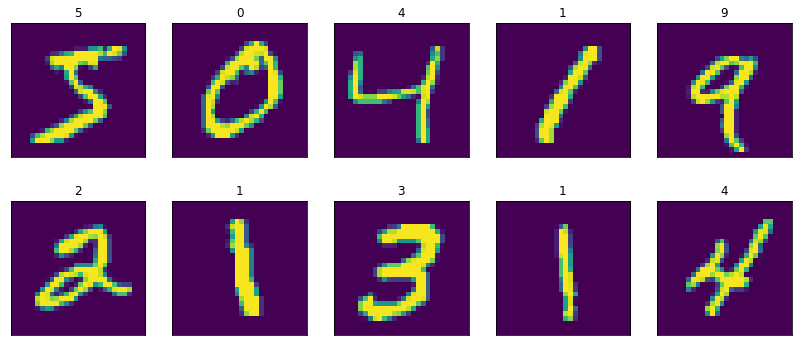

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title('%d' % y_train[i])
plt.show()

The `y_train` and `y_target` values are currently integers (0 to 9).  The output from our network is a vector where one value should be 1 and the others should be 0, so we need to convert to that format.  (Note: there is a special loss function `sparse_categorical_crossentropy` that automatically converts for us.  We'll use that later, but for now do this manually, just to keep things clear.)

In [4]:
import numpy as np

y_train_target = np.eye(10)[y_train]
y_test_target = np.eye(10)[y_test]
print('original target:', y_train[0])
print('  vector target:', y_train_target[0])

original target: 5
  vector target: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Now we define the model using Keras https://keras.io/, which is meant for being able to quickly define all the different structures you might want to add to your network. We use `Sequential` to indicate that this is just a big feed-forward network, and we define each layer in turn.  `Dense` is a layer where all the components are connected to all of the previous layer's outputs.

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
])

# define what we want to minimize (the thing that we take the derivative of to get the weight changes)
def my_loss(y_true, y_predict):
    return (y_true-y_predict)**2

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
              loss=my_loss,
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

Before doing any training, let's see how well it performs.

In [6]:
loss, accuracy = model.evaluate(x_test,  y_test_target, verbose=0)
print("Loss: " + str(loss))
print("Accuracy: " + str(accuracy))

Loss: 0.12069813373088836
Accuracy: 0.103


As expected, it's pretty bad, since we haven't done any training yet.  The accuracy is near 10%, which is what we would expect by chance.  But what actual numbers is it outputting?

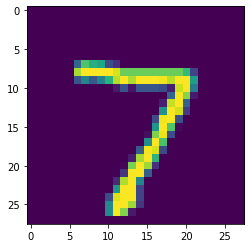

actual output from network: [0.         0.         0.         0.         0.01807496 0.08556172
 0.         0.18155557 0.24481636 0.23043056]
category (the largest output): 8


In [7]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])


So it currently thinks the first image in the test dataset is is a 1, when it should actually be a 7.  

Now let's try training the model.  We'll just do 5 epochs of training (5 times through all the training data).  While it is training, we also tell it to see how well the model is performing on the testing data (technically this is considered to be validation data).

In [8]:
model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target));

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0384 - accuracy: 0.7773 - val_loss: 0.0284 - val_accuracy: 0.8690
Epoch 2/5
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0274 - accuracy: 0.8762 - val_loss: 0.0253 - val_accuracy: 0.8963
Epoch 3/5
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0249 - accuracy: 0.8968 - val_loss: 0.0239 - val_accuracy: 0.9063
Epoch 4/5
60000/60000 [==============================] - 4s 71us/sample - loss: 0.0235 - accuracy: 0.9084 - val_loss: 0.0228 - val_accuracy: 0.9091
Epoch 5/5
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0225 - accuracy: 0.9174 - val_loss: 0.0220 - val_accuracy: 0.9183


We can plot the categorization accuracy over time and the error over time for both the training set and the test set.

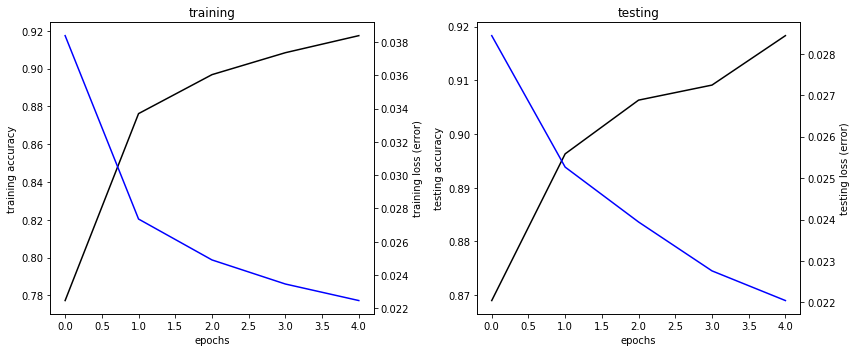

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'], c='k')
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['loss'], c='b')
plt.ylabel('training loss (error)')
plt.title('training')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['val_accuracy'], c='k')
plt.ylabel('testing accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.plot(model.history.history['val_loss'], c='b')
plt.ylabel('testing loss (error)')
plt.title('testing')
plt.tight_layout()
plt.show()

Now let's see how well it performs on the test set.

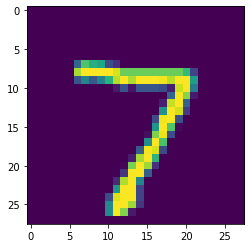

actual output from network: [0.         0.         0.         0.08790164 0.         0.
 0.         0.8551434  0.         0.        ]
category (the largest output): 7


In [10]:
output = model.predict(x_test)
category = np.argmax(output, axis=1)

plt.imshow(x_test[0])
plt.show()
print('actual output from network:', output[0])
print('category (the largest output):', category[0])

Well it learned the first item well, but it's only getting around 85% on the test set (which is also about what it's getting on the training set).  To get a better sense of what it's doing, let's generate the *confusion* matrix.  This indicates what category it puts things in, as compared to what category they should be in.

In [11]:
confusion=np.zeros((10,10), dtype=int)
np.add.at(confusion, (category, y_test), 1)
print(confusion)

[[ 702    0    5    1    0    2    0    1    1    7]
 [   0 1118    0    0    2    2    3   17    2    7]
 [  61    4  967   16    5    3    3   17   12    0]
 [  28    3    8  955    1   28    2    2   10   17]
 [  27    1   12    0  944    9   13   10   12   53]
 [  84    0    0   10    0  803   10    1    8    7]
 [  48    3    9    2    7   20  923    1   13    2]
 [   7    1   11   12    1    4    0  955    4    8]
 [  20    5   18    9    5   15    4    1  911    3]
 [   3    0    2    5   17    6    0   23    1  905]]


The ideal confusion matrix will have ~1000 along the diagonal and 0 everywhere else.  According to this confusion matrix, the only classified 1 thing as a 9, and that was actually a 4.  Instead, 9s are usually classified as a 0 (479 of the 9s are classified as 0s).  

The last sentence above is incorrect for this specific model when we trained it initially. 

**1. [1 mark]:** Run the MNIST model as defined here 10 times.  Note that you have to re-create the `model` each time: if you just run `model.fit` over again, then it will just train the same model, continuing from where it left off.  Each of the 10 models should be trained for 5 epochs.  Make a single plot with training accuracy vs epoch for all 10 runs. You should see that each time you train the model, it behaves differently.  Why does this happen? 

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


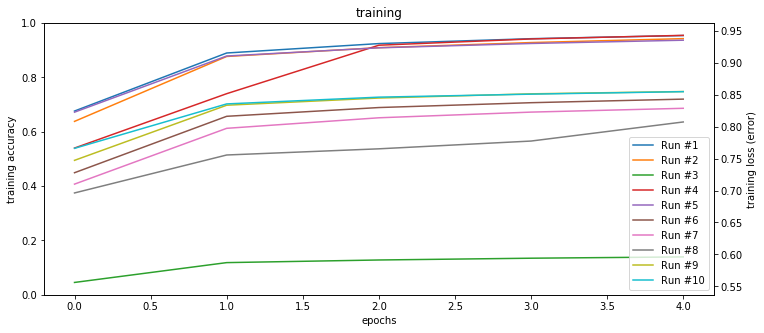

In [ ]:
num_runs = 10
plt.figure(figsize=(12,5))
plt.ylabel('training accuracy')
plt.xlabel('epochs')
plt.twinx()
plt.title('training')
for i in range(1,num_runs+1):
    print("Run #: {}/10".format(i))
    # define the model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
        tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
        tf.keras.layers.Dense(10, activation='relu')     # 10 outputs (one for each category)
    ])
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), # use stochastic gradient descent
                  loss=my_loss,
                  metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                 )
    # fit the model
    model.fit(x_train, y_train_target, epochs=5, validation_data=(x_test, y_test_target), verbose=0)
    # plot
    plt.plot(model.history.history['accuracy'], label="Run #{}".format(i))
plt.legend(loc = "best")
plt.show()

As seen above, it is evident that each time we train the model it behaves differently. This is because machine learning algorithms in general are non-deterministic, and so each time we run an algorithm, the outcome will vary. This is a result of the random initialization of weights for each model. If we want to make the results reproducible, then we have to eliminate the random initialization of weights, which can be done using a fixed random seed.
Another possible reason, that we aren't sure of, could be because the training data isn't always fed into the model the same way each time in the same order. We are not too familiar with the libraries to know the exact implementation.

**2. [1 mark]:** Do the same thing as question 1, but train for 20 epochs.  Plot the training error vs epochs for 10 different runs on one plot.  On a separate plot show the testing error vs epochs for the 10 different runs.  How does the testing error compare to the training error?  Do the models all eventually learn to solve the problem well?  What happens to them?

In [ ]:
def qx(learning_rate, opt="", error="", output_act="", ytrain="", num_epochs=20):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    num_runs = 10
    axs[0].set_ylabel('training loss (error)')
    axs[0].set_xlabel('epochs')
    axs[0].set_title('training')
    axs[1].set_ylabel('testing loss (error)')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('testing')
    for i in range(1,num_runs+1):
        print("Run #: {}/10".format(i))
        # define the model
        output_activation = 'relu' if (output_act=="") else 'softmax'
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
            tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(10, activation=output_activation)     # 10 outputs (one for each category)
        ])
        # compile the model
        optimize = tf.keras.optimizers.SGD(learning_rate) if (opt == "") else "adam"
        my_error = my_loss if (error == "") else 'sparse_categorical_crossentropy'
        model.compile(optimizer=optimize, # use stochastic gradient descent
                      loss=my_error,
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                     )
        # fit the model
        my_ytrain = y_train_target if (ytrain == "") else y_train
        my_ytest = y_test_target if (ytrain == "") else y_test
        model.fit(x_train, my_ytrain, epochs=num_epochs, validation_data=(x_test, my_ytest), verbose=0)
        # plot
        axs[0].plot(model.history.history['loss'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_loss'], label="Run #{}".format(i))
    axs[0].legend(loc = "best")
    axs[1].legend(loc = "best")
    plt.tight_layout()

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


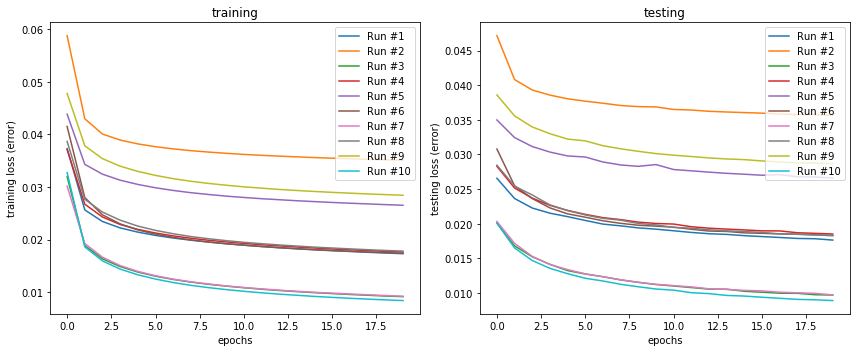

In [ ]:
qx(0.1)

It seems that the testing error is usually greater than the training error (after the final training epoch), which intuitively makes sense, as a model will always perform better on it's training data that it has already been tested on than new data. It also seems that the testing error is proportional to the training error, meaning runs which exhibited the largest amount of training errors also exhibited the largest amount of testing errors. Given that the final training and testing errors are bounded between 1% - 4%, we can say this model is now solving the problem reasonably well. The learning process leverages gradient descent to achieve optimal weights, given the restriction of the learning rate.

**3. [1 mark]:** Repeat question 2 (generating the same 2 plots), but with a learning rate of 0.01.  How does this affect the learning performance?

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


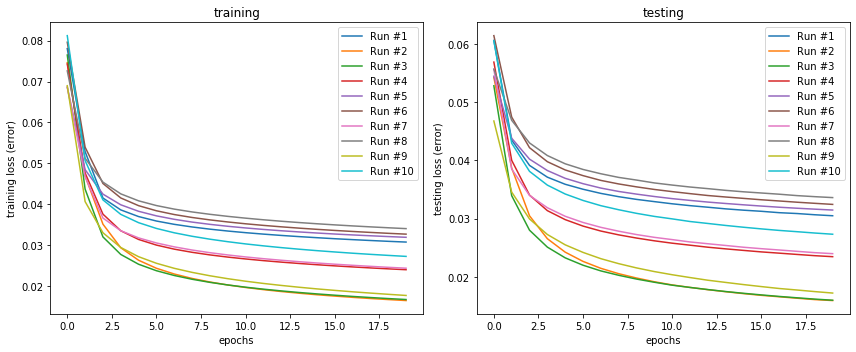

In [ ]:
qx(0.01)

The starting point, which is essentially random, is a little different in this experiment than the last, but we can see that by decreasing the learning rate, the range of loss accuracy has shifted to about 2% - 4%, making it slightly worse than the previous model which had a range of loss accuracy of about 1% - 4%.

**4. [1 mark]:** Instead of standard Stochastic Gradient Descent, most modern machine learning researchers use a variation of it called Adam that automatically adjusts the learning rate and does a better local estimate of the gradient.  We can switch to this by changing `optimizer=tf.keras.optimizers.SGD(learning_rate=0.1)` to `optimizer="adam"`.  Repeat question 2 (generating the same 2 plots) using the Adam optimizer.  How does this affect the learning performance?

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


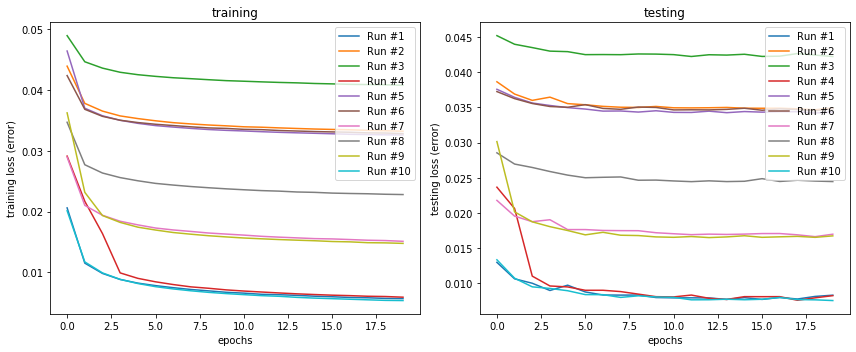

In [ ]:
qx(0.1, "adam")

We can see that the range of final loss accuracy has changed to about 0.5% - 4.5%, allowing for a greater variance of accuracy. Moreover, by using Adam, and in turn adjusting the learning rate to have a better local estimate of the gradient, the model learns a lot faster as seen in the graphs above. Each of the models approximately reaches its accuracy plateau (at which the accuracy only marginally improves with more epochs) earlier than previously where we used a fixed learning rate.

**5. [1 mark]**: To improve performance, we can also change the output layer of neurons to be a `softmax` layer.  This means that they will automatically be normalized with the softmax function (so the output of neuron $i$ will be ${e^{a_i} / \sum_j e^{a_j}}$).  This should push the output value closer to the sort of output we want (all zeros with a single 1).  Furthermore, instead of doing the error as $(t-y)^2$, we can instead choose an error function that is only concerned about categorization.  After all, the only thing we care about when categorizing is which of the outputs is largest, not whether they are exactly 0 or 1.  Conveniently, tensorflow (and many other deep learning libraries) also contains a version of this function that works directly on category labels, so we don't have to do the `y_train_target = np.eye(10)[y_train]` trick in the code above.  The resulting network looks like this:

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


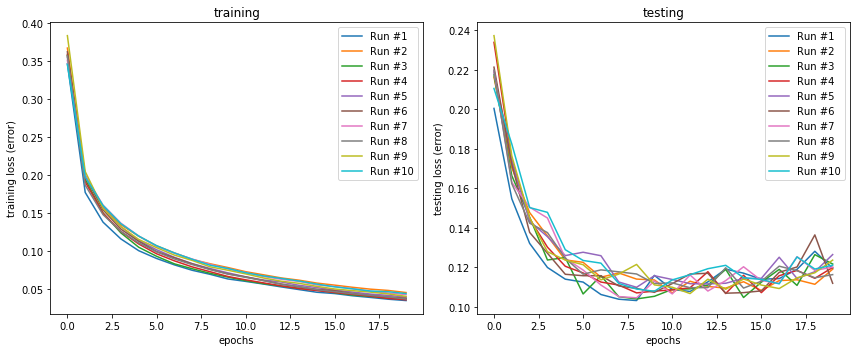

In [ ]:
"""
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
  tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
  tf.keras.layers.Dense(10, activation='softmax')  # 10 outputs (one for each category)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
             )

model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test))   # note that we now use y_train, not y_train_target
"""
qx(0.1, "adam", "sparse_categorical_crossentropy", "softmax", "y_train")

Generate the same 2 plots as in question 2.  How do these changes affect the learning performance?

It’s hard to exactly compare the outputs from question four to the outputs of this question as we are measuring different things (as our definition of error has changed), but it seems that using this new loss function has resulted in a smooth decrement in training loss, though neither smoothness nor monotonicity can be used to define testing loss. 

**6. [2 marks]:** Using the final version of the model (from question 5), explore the performance of the model as you change the number of neurons in the hidden layer.  Try 2, 4, 8, 16, 32, 64, 128, and 256.  For each value, train 10 models for 10 epochs each.  We do not need the testing accuracy over the epochs, so you can switch back to setting `epochs=10` rather than using the `for` loop.  Plot the average training accuracy vs different numbers of neurons.  On a separate plot, plot the average testing accuracy vs different numbers of neurons.  What trend do you observe?

In [ ]:
# This is the same model from Question 5, but with some additional options for modifications
def q6(neurons, num_epochs=10,inp_shape=(28,28)):
    num_runs = 10
    train_acc_nums = []
    test_acc_nums = []
    for i in range(1,num_runs+1):
        # define the model
        output_activation = 'softmax'
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=inp_shape),   # input is a 28x28 image
            tf.keras.layers.Dense(neurons, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(10, activation=output_activation)     # 10 outputs (one for each category)
        ])
        # compile the model
        model.compile(optimizer='adam', # use stochastic gradient descent
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                     )
        # fit the model
        model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_test, y_test), verbose=0)
        train_acc_nums.append(model.history.history['accuracy'][-1])
        test_acc_nums.append(model.history.history['val_accuracy'][-1])
    return np.mean(train_acc_nums), np.mean(test_acc_nums)

In [ ]:
train_acc = []
test_acc = []
neuron_nums = [2, 4, 8, 16, 32, 64, 128, 256]
for i in neuron_nums:
    print("Neurons: {}".format(i))
    train, test = q6(i)
    train_acc.append(train)
    test_acc.append(test)

Neurons: 2
Neurons: 4
Neurons: 8
Neurons: 16
Neurons: 32
Neurons: 64
Neurons: 128
Neurons: 256


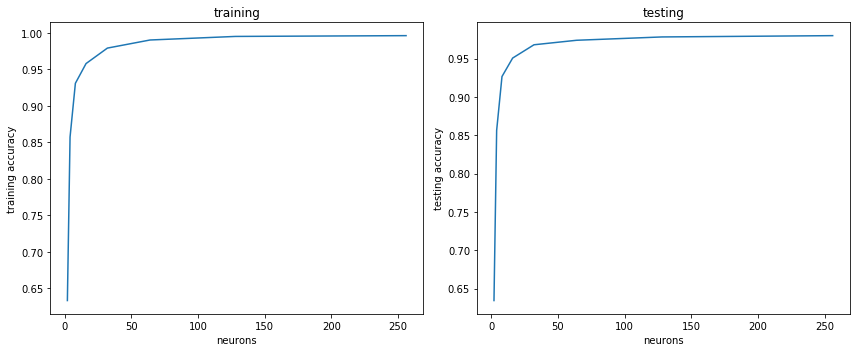

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].set_ylabel('training accuracy')
axs[0].set_xlabel('neurons')
axs[0].set_title('training')
axs[1].set_ylabel('testing accuracy')
axs[1].set_xlabel('neurons')
axs[1].set_title('testing')

axs[0].plot(neuron_nums, train_acc)
axs[1].plot(neuron_nums, test_acc)
plt.tight_layout()
plt.show()

As would be expected, accuracy increases as more neurons are used. What we did not expect was that accuracy would increase at such an increasingly large rate as neurons increased from very low numbers. However it seems that after about 128 neurons, the accuracy becomes nearly stagnant, deeming it computationally unnecessary to introduce more neurons for this specific model.

**7. [2 marks]:** The overall goal is to make the network perform as well as possible on the testing data.  What would you do if your job was to make the best possible network for this task?  Try some things and report your results.  For example, try adding a second hidden layer to the model.  Try making it different sizes. What about having no hidden layer?  Or more than 2?  Report the results of your exploration.

In [14]:
import numpy as np

def q7_e1(learning_rate, opt="", error="", output_act="", ytrain="", num_epochs=20):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    num_runs = 10
    axs[0].set_ylabel('training loss (error)')
    axs[0].set_xlabel('epochs')
    axs[0].set_title('training')
    axs[1].set_ylabel('testing loss (error)')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('testing')
    for i in range(1,num_runs+1):
        print("Run #: {}/10".format(i))
        # define the model
        output_activation = 'relu' if (output_act=="") else 'softmax'
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
            tf.keras.layers.Dense(10, activation=output_activation)     # 10 outputs (one for each category)
        ])
        # compile the model
        optimize = tf.keras.optimizers.SGD(learning_rate) if (opt == "") else "adam"
        my_error = my_loss if (error == "") else 'sparse_categorical_crossentropy'
        model.compile(optimizer=optimize, # use stochastic gradient descent
                      loss=my_error,
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                     )
        # fit the model
        my_ytrain = y_train_target if (ytrain == "") else y_train
        my_ytest = y_test_target if (ytrain == "") else y_test
        model.fit(x_train, my_ytrain, epochs=num_epochs, validation_data=(x_test, my_ytest), verbose=0)
        # plot
        axs[0].plot(model.history.history['accuracy'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_accuracy'], label="Run #{}".format(i))
    axs[0].legend(loc = "best")
    axs[1].legend(loc = "best")
    plt.tight_layout()

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


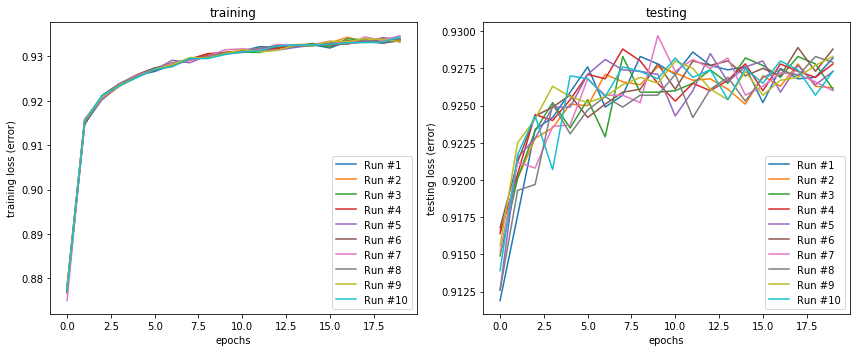

In [15]:
q7_e1(0.1, "adam", "sparse_categorical_crossentropy", "softmax", "y_train")

In [16]:
def q7_e2(learning_rate, opt="", error="", output_act="", ytrain="", num_epochs=20):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    num_runs = 10
    axs[0].set_ylabel('training loss (error)')
    axs[0].set_xlabel('epochs')
    axs[0].set_title('training')
    axs[1].set_ylabel('testing loss (error)')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('testing')
    for i in range(1,num_runs+1):
        print("Run #: {}/10".format(i))
        # define the model
        output_activation = 'relu' if (output_act=="") else 'softmax'
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
            tf.keras.layers.Dense(64, activation='relu'),    # 64 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(10, activation=output_activation)     # 10 outputs (one for each category)
        ])
        # compile the model
        optimize = tf.keras.optimizers.SGD(learning_rate) if (opt == "") else "adam"
        my_error = my_loss if (error == "") else 'sparse_categorical_crossentropy'
        model.compile(optimizer=optimize, # use stochastic gradient descent
                      loss=my_error,
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                     )
        # fit the model
        my_ytrain = y_train_target if (ytrain == "") else y_train
        my_ytest = y_test_target if (ytrain == "") else y_test
        model.fit(x_train, my_ytrain, epochs=num_epochs, validation_data=(x_test, my_ytest), verbose=0)
        # plot
        axs[0].plot(model.history.history['accuracy'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_accuracy'], label="Run #{}".format(i))
    axs[0].legend(loc = "best")
    axs[1].legend(loc = "best")
    plt.tight_layout()

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


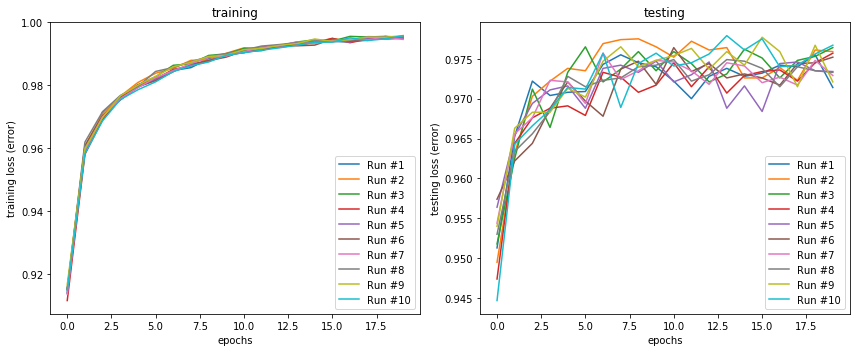

In [17]:
q7_e2(0.1, "adam", "sparse_categorical_crossentropy", "softmax", "y_train")

In [18]:
def q7_e3(learning_rate, opt="", error="", output_act="", ytrain="", num_epochs=20):
    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    num_runs = 10
    axs[0].set_ylabel('training loss (error)')
    axs[0].set_xlabel('epochs')
    axs[0].set_title('training')
    axs[1].set_ylabel('testing loss (error)')
    axs[1].set_xlabel('epochs')
    axs[1].set_title('testing')
    for i in range(1,num_runs+1):
        print("Run #: {}/10".format(i))
        # define the model
        output_activation = 'relu' if (output_act=="") else 'softmax'
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),   # input is a 28x28 image
            tf.keras.layers.Dense(64, activation='relu'),    # 64 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(32, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(16, activation='relu'),    # 16 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(10, activation=output_activation)     # 10 outputs (one for each category)
        ])
        # compile the model
        optimize = tf.keras.optimizers.SGD(learning_rate) if (opt == "") else "adam"
        my_error = my_loss if (error == "") else 'sparse_categorical_crossentropy'
        model.compile(optimizer=optimize, # use stochastic gradient descent
                      loss=my_error,
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                     )
        # fit the model
        my_ytrain = y_train_target if (ytrain == "") else y_train
        my_ytest = y_test_target if (ytrain == "") else y_test
        model.fit(x_train, my_ytrain, epochs=num_epochs, validation_data=(x_test, my_ytest), verbose=0)
        # plot
        axs[0].plot(model.history.history['accuracy'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_accuracy'], label="Run #{}".format(i))
    axs[0].legend(loc = "best")
    axs[1].legend(loc = "best")
    plt.tight_layout()

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


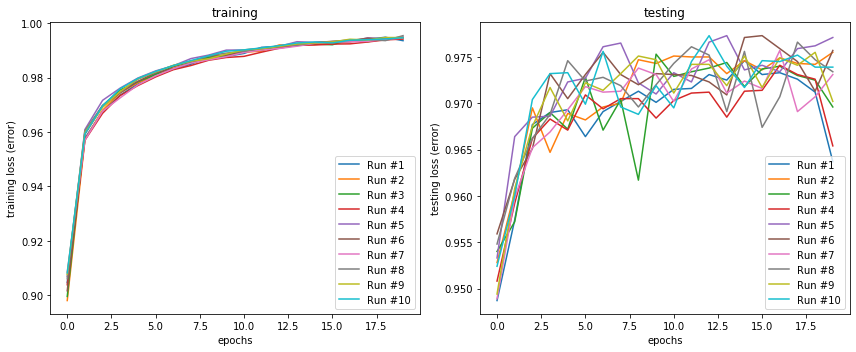

In [19]:
q7_e3(0.1, "adam", "sparse_categorical_crossentropy", "softmax", "y_train")

It seems that completely removing the hidden layer decreased accuracy, but only to about 92.5% on average which is not as bad as we were expecting. 

Having two or more hidden layers increased performance with regards to accuracy in the models. 

We also attempted to have the layers decrease in the number of neurons from 64 to 32 neurons, and then an additional 16 neuron layer before the final 10 neuron output in experiment three. It seems that an addition layer in this specific case did not achieve any significant additional accuracy.

After doing question Part 2 of this assignment, perhaps adding a convolutional layer would increase accuracy as well in this model, but the model performs quite well even without it as seen in Experiment 2.

## Part 2: CIFAR-10

The CIFAR-10 dataset is a bit harder than the MNIST dataset.  Like MNIST, it consists of 10 categories of images, but now they are colour images and they are of different types of objects.

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scale pixel values to be between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0
y_test = y_test[:,0]

170500096/170498071 [==============================] - 2s 0us/step


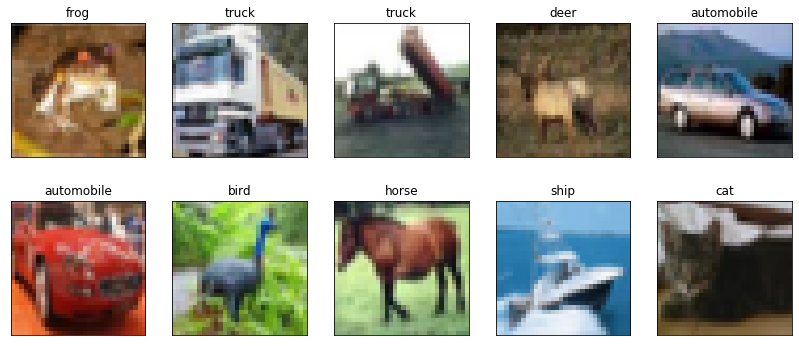

In [13]:
plt.figure(figsize=(14,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(names[int(y_train[i])])
plt.show()

**8. [2 marks]:** Try using the same model as we used for the MNIST (question 5) task to categorize these images.  You will need to change `input_shape=(28, 28)` to `input_shape=(32, 32, 3)`, as these are now colour images of a different size.  Use 32 neurons in the hidden layer and train for 10 epochs.  Do this 10 times and plot the training accuracy and testing accuracy.  How well does the model perform?  Try increasing the number of hidden layer neurons (pick a number of neurons that seems reasonable given how much computer processing power you have).  How much does the system improve?

In [ ]:
def q8(neurons):
  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  axs[0].set_ylabel('training accuracy')
  axs[0].set_xlabel('epochs')
  axs[0].set_title('training')
  axs[1].set_ylabel('testing accuracy')
  axs[1].set_xlabel('epochs')
  axs[1].set_title('testing')

  num_runs = 10
  for i in range(1,num_runs+1):
        # define the model
        output_activation = 'softmax'
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(32, 32, 3)),  
            tf.keras.layers.Dense(neurons, activation='relu'),    # 32 neurons in the middle "hidden" layer
            tf.keras.layers.Dense(10, activation=output_activation)     # 10 outputs (one for each category)
        ])
        # compile the model
        model.compile(optimizer='adam', # use stochastic gradient descent
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                      )
        # fit the model
        model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
        axs[0].plot(model.history.history['accuracy'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_accuracy'], label="Run #{}".format(i))
  axs[0].legend(loc = "best")
  axs[1].legend(loc = "best")

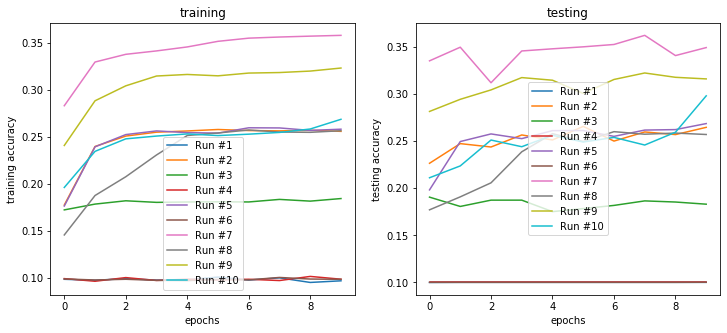

In [ ]:
q8(32)

With 32 neurons, this model does not perform well in either training accuracy or testing accuracy as seen in the graphs above. In all 10 runs, the highest accuracy was only approximately 35% in both training and testing, which is not relatively very good in performance.

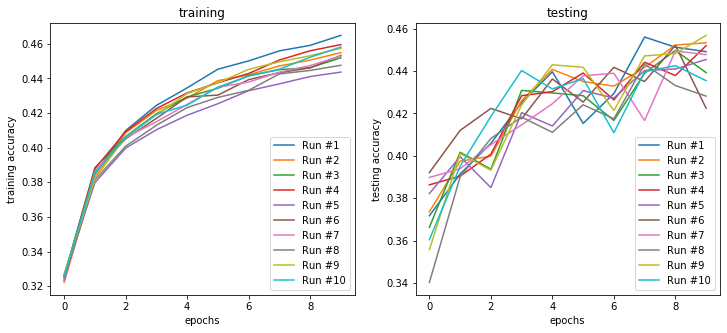

In [ ]:
q8(256) # 256 neurons

With 256 neurons, we can clearly see there's a significant increase in model performance in both training and testing accuracy when compared to the model with 32 neurons. The 32 neuron model only reached approximately a max of 35% training and testing accuracy, whereas this 256 neuron model reaches a max of approximately 46% training and testing accuracy, and the minimum accuracy is much higher than the 32 neuron model's max of approximately 35% accuracy. However, we must note that this 256 neuron model was significantly more expensive in terms of computational resources used. Overall however, even this 256 neuron model does not perform very well as the accuracy is only a maximum of approximately 46% which is not relatively high.

**9. [2 marks]:** To solve this task, let's try adding more layers.  In particular, let's add convolutional layers.  Here is a good network structure to start with:

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.Flatten(),    
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
def q9():
  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  axs[0].set_ylabel('training accuracy')
  axs[0].set_xlabel('epochs')
  axs[0].set_title('training')
  axs[1].set_ylabel('testing accuracy')
  axs[1].set_xlabel('epochs')
  axs[1].set_title('testing')

  num_runs = 10
  for i in range(1,num_runs+1):
        print("Run #: {}/10".format(i))
        # define the model
        output_activation = 'softmax'
        model = tf.keras.models.Sequential([
          tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
          tf.keras.layers.Flatten(),    
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(10, activation='softmax')
        ])
        # compile the model
        model.compile(optimizer='adam', # use stochastic gradient descent
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                      )
        # fit the model
        model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
        axs[0].plot(model.history.history['accuracy'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_accuracy'], label="Run #{}".format(i))
  axs[0].legend(loc = "best")
  axs[1].legend(loc = "best")

Train this network for 10 epochs, and do this 10 times and plot the training and testing accorcay.  How well does the model perform?  

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


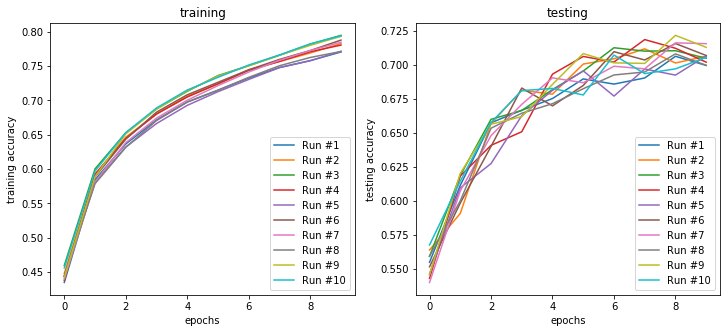

In [ ]:
q9()

With the added convolutional layers, this model performs much better than the previous models with 32 neurons and 256 neurons as this model reaches training accuracies of approximately 77% and testing accuracies of approximately 70%, both of which are much higher than the approximately 35% and 46% accuracies of the 32 and 256 neuron models respectively. Once again, we must note that this model was also computationally expensive due to the added layers and convolutional layers. This model performs relatively well, but perhaps larger model architectures could increase performance/accuracy even more.

**10. [2 marks]:** Improve the model as much as you can.  Remember that the goal is to increase the testing accuracy, not the training accuracy (after all, if we wanted perfect training accuracy, we could just write code that just memorizes all the training data and uses it as a lookup table).  Report what things you tried and how much they helped (or did not help).

In [20]:
def q10_1():
  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  axs[0].set_ylabel('training accuracy')
  axs[0].set_xlabel('epochs')
  axs[0].set_title('training')
  axs[1].set_ylabel('testing accuracy')
  axs[1].set_xlabel('epochs')
  axs[1].set_title('testing')

  num_runs = 10
  for i in range(1,num_runs+1):
        print("Run #: {}/10".format(i))
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), 
                                         padding="same", use_bias=False))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))
        model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(128, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(10, activation='softmax'))

        # compile the model
        model.compile(optimizer='adam', # use stochastic gradient descent
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']  # in addition to the loss, also compute the categorization accuracy
                      )
        # fit the model
        model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), verbose=0)
        axs[0].plot(model.history.history['accuracy'], label="Run #{}".format(i))
        axs[1].plot(model.history.history['val_accuracy'], label="Run #{}".format(i))
  axs[0].legend(loc = "best")
  axs[1].legend(loc = "best")

Run #: 1/10
Run #: 2/10
Run #: 3/10
Run #: 4/10
Run #: 5/10
Run #: 6/10
Run #: 7/10
Run #: 8/10
Run #: 9/10
Run #: 10/10


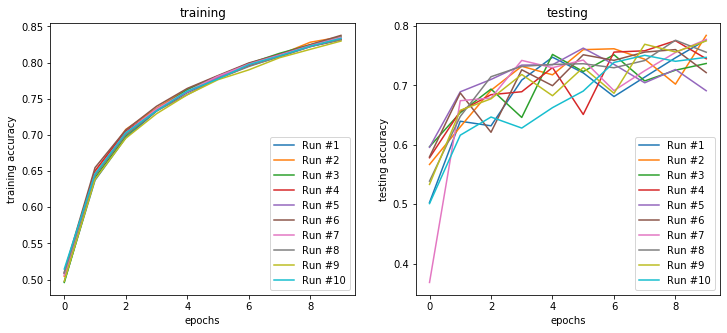

In [17]:
q10_1()

What did we try and how did it help?

**Batch Normalization**

We tried adding batch normalization for slightly faster training and possible increases in performance with regards to accuracy, and it did result in a slightly greater increase in accuracy. We did not measure the training time increase, but even if there was an increase, it does not seem very significant as it took relatively the same amount of time to do 10 runs with 10 epochs.

**Dropout**

We also added dropout of hidden units in layers, which refers to ignoring randomly chosen units/neurons in the training phase. This means they are not considered in a particular forward or backward pass. We decided to use dropout to prevent overfitting of the training data since overfitting can result in great training accuracies but poor testing accuracies. With some research on dropout, we learned that dropout roughly doubles the number of iterations required to converge, but reduces the training time for each epoch. This can actually be seen in the graphs above compared to the graphs in question 9 with regards to the testing accuracy convergence. With dropout, we can clearly see that the models are not converging as quickly as they were in question 9, but the testing accuracy is indeed slightly higher with the testing accuracies averaging around 76% compared to Q9's 70%.

**Additional Convolutional Layers**

We also decided to increase the size of our model using more convolutional layers to aid in extraction of features from the images. This did result in a slight increase of accuracy as well, but it definitely resulted in an increase in computational resources required as well because of the extra computations the model would perform.

**Overall**

With the three modifications combined from above, we were able to get an increase in testing accuracy of approximately 6% from 70% to 76%, but we would have loved to experiment with larger model architectures and see how those performed. However, due to the limited computational resources we have available on our local machines, we were unable to successfully experiment with larger models in a reasonable amount of time. Moreover, we did not know if we were allowed to increase the number of epochs per model, so we didn't try that, but we definitely think that would increase testing accuracies as well (of course, with more computational resources required with regards to time). 